## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Computing the camera calibration using chessboard images

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from collections import deque
from itertools import islice
%matplotlib inline

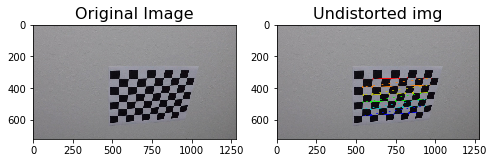

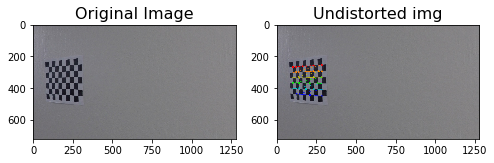

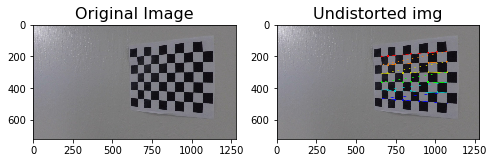

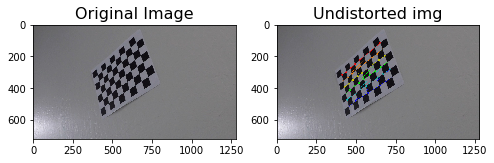

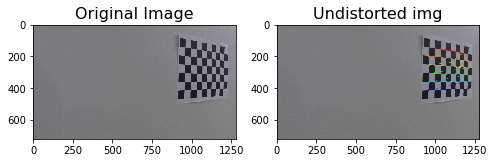

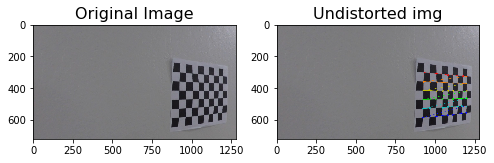

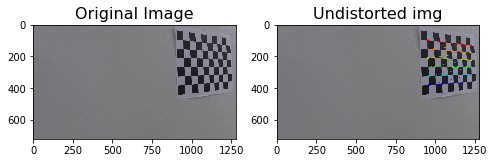

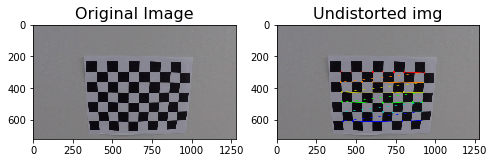

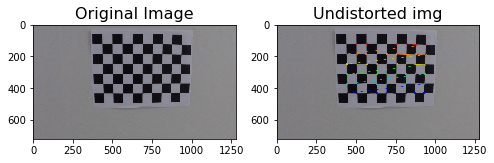

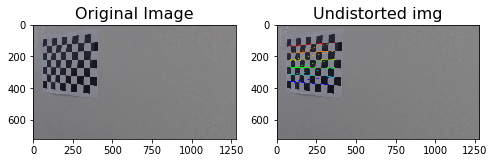

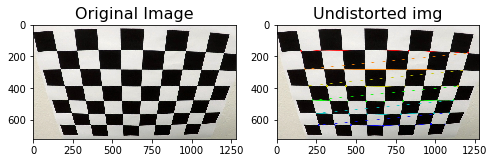

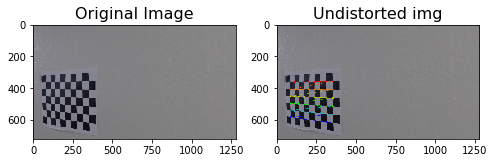

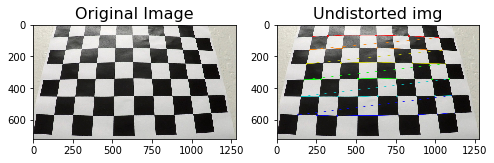

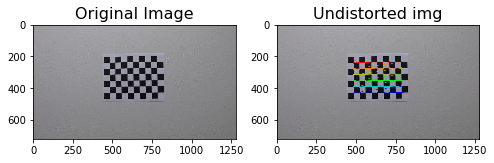

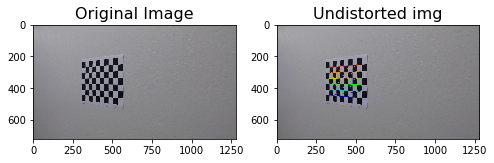

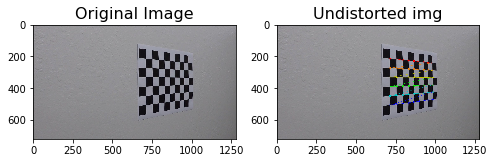

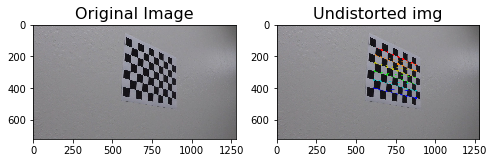

In [6]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted image', fontsize=16)
        
# Create calibration of the camera, calibrate distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Apply a distortion correction to raw images.

In [7]:
def undst(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [8]:
# Lets check an undistorted image:
test_img = cv2.imread("../test_images/test5.jpg")
undst_img = undst(test_img)

In [9]:
cv2.imshow("img",  undst_img)
cv2.imwrite("../output_images/undistorted.jpg", undst_img)

True

In [10]:
undst_img.shape

(720, 1280, 3)

## Thresholding an image

In [11]:
# Lets use the undistorted image to:
# 1. calculate gradients: - This approach leaves a lot of noise on  the picture
# 2. change to HLS, and use the S dimension

# Use the function from class
def magnitude(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [12]:
sbinary = magnitude(undst_img, 3, mag_thresh=(70, 100))

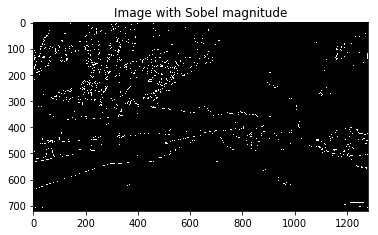

In [13]:
%matplotlib inline
plt.imshow(sbinary, cmap="gray")
plt.title("Image with Sobel magnitude")
plt.imsave("../output_images/abs_sobel_mag.jpg", sbinary)

In [14]:
def hls(img, s_thresh_min = 205, s_thresh_max = 255):
    # Change to HLS and use S
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Get only the s channel
    s_img = hls_img[:, :, 2]
    # We can see, that by default, it picks up the lines really nicely. 
    #plt.imshow(s_img, cmap="gray")

    # But we can do better by thresholding:
    s_binary = np.zeros_like(s_img)
    s_binary[(s_img >= s_thresh_min) & (s_img <= s_thresh_max)] = 1
    
    return s_binary

In [15]:
s_binary = hls(undst_img)

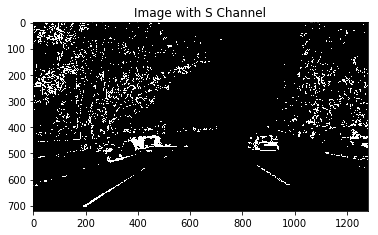

In [17]:
plt.imshow(s_binary, cmap="gray")
plt.title("Image with S Channel")
plt.imsave("../output_images/s_channel_binary.jpg", s_binary)

In [18]:
def l_b_transform(img,  bmin=150, bmax=200, lmin=230, lmax=255):
    #  Ihave  also read about LUV and Lab colorspaces to do a good job in this assignemnt,
    # I will use them as well
    l_trans = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_trans = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2] 
    b_binary = np.zeros_like(b_trans)
    b_binary[(b_trans >= bmin) & (b_trans <= bmax)] = 1
    l_binary = np.zeros_like(b_trans)
    l_binary[(b_trans >= lmin) & (b_trans <= lmax)] = 1
    
    combined_lb = np.zeros_like(s_binary)
    combined_lb[(l_binary == 1) | (b_binary == 1)] = 1
    
    return combined_lb

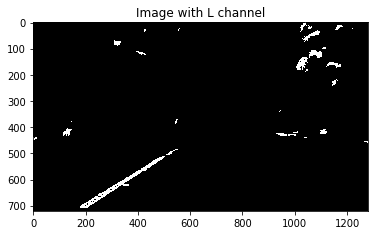

In [23]:
lb_img = l_b_transform(undst_img)
plt.title("Image with L channel")
plt.imshow(lb_img, cmap="gray")
plt.imsave("../output_images/l_binary.jpg", lb_img)

In [24]:
# Combining the two with the help of a function:
def combine(sobel, s, lb):
    combined_binary = np.zeros_like(sobel)
    combined_binary[(s == 1) | (lb==1)] = 1
    
    return combined_binary

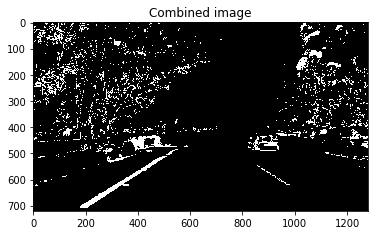

In [25]:
combined_binary = combine(sbinary, s_binary, lb_img)
plt.imshow(combined_binary, cmap="gray")
plt.title("Combined image")
plt.imsave("../output_images/combined_binary.jpg", combined_binary)

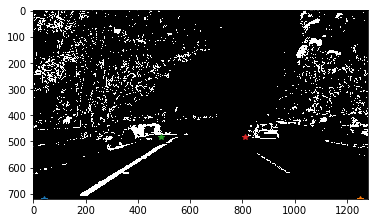

In [26]:
# The points to be warped:
plt.imshow(combined_binary, cmap="gray")
plt.plot(40, 719, "*")
plt.plot(1250, 719, "*")
plt.plot(490, 482, "*")
plt.plot(810, 482, "*")

In [27]:
combined_binary.shape

(720, 1280)

## Birds eye view

In [28]:
def birds_eye(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

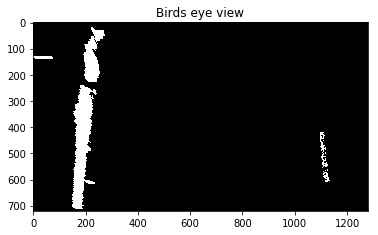

In [47]:
binary_warped, Minv = birds_eye(combined_binary)
plt.imshow(binary_warped, cmap="gray")
plt.title("Birds eye view")
plt.imsave("../output_images/birds.jpg", binary_warped)

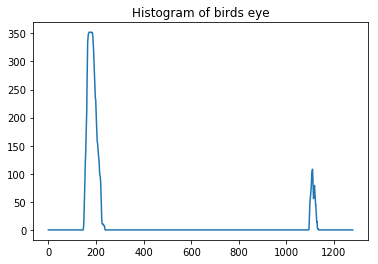

In [33]:
# Use histogram to get two initial lines
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.title("Histogram of birds eye")
plt.plot(histogram)

In [41]:
# Process image before giving it to the class
def process_image(img):
    undst_img = undst(img)
    sbinary = magnitude(undst_img, 3, mag_thresh=(70, 100))
    s_binary = hls(undst_img)
    lb_img = l_b_transform(undst_img)
    combined_binary = combine(sbinary, s_binary, lb_img)
    binary_warped, Minv = birds_eye(combined_binary)
    
    warped_left  = np.copy(binary_warped)
    warped_right = np.copy(binary_warped)

    warped_left[:, 540:] = [0]
    warped_right[:, :540] = [0]
    
    return binary_warped, warped_left, warped_right, Minv

In [44]:
binary_warped, wleft, wright, _ = process_image(test_img)

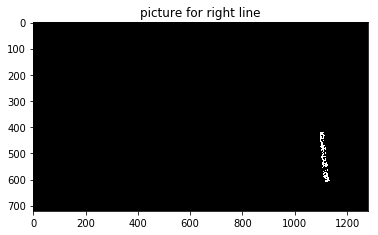

In [93]:
plt.imshow(wleft, cmap="gray")
plt.title("picture for left line")
plt.imsave("../output_images/leftline.jpg", wleft)

plt.imshow(wright, cmap="gray")
plt.title("picture for right line")
plt.imsave("../output_images/rightline.jpg", wright)

### The Line() class can take in one picture at a time, and has memory of last findings. Lets see it on one picture!
There are one line for the left and one for the right side of the lane

In [100]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.X_values =  deque(maxlen=10)
        self.y_values =  deque(maxlen=10)

        self.bestx = None   
        self.fits = deque(maxlen=10)
        self.wrong_fits = deque(maxlen=10)
        #Coefficients to draw lines
        
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = deque(maxlen=20) 

        #Where the line starts
        self.line_base_pos = None
        # Last 10 line positions
        self.first_bases = deque(maxlen=10)
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = np.array([])  
        #y values for detected line pixels
        self.ally = np.array([])
        
        # Counts images seen - important for start values
        self.images_seen = 0
        # Count images with detected -> resets if seen
        self.not_seen    = 0
        
        # Weighted fit (averaged over last 10 iterations)
        self.weighted_fit = None
        
        # A fit from a previous fit
        self.previous_fit = np.array([ -3.34632573e-05,  -2.43400011e-02,   2.96260481e+02])
        
    def count_images_seen(self):
        '''
        This  function counts the images seen and sets the fits and bases to average values
        '''
        self.images_seen += 1
        if self.weighted_fit is None:
            self.previous_fit = self.current_fit
        else:
            self.previous_fit = self.weighted_fit
        if len(self.first_bases) > 3:
            self.previous_base = np.mean(self.first_bases)
        
        
    def get_polynomials(self, warped_img, nwindows = 9, margin=100, minpix=50, threshold=40):
        '''
        This function does most of the job, given the picture, calculates the curvature.
        Based on the 
        '''

        #if self.detected is False or len(self.first_bases) < 2 or self.not_seen > 2:
        if self.images_seen==0:
            self.img_size = warped_img.shape
            self.ploty = np.linspace(0, self.img_size[0]-1, self.img_size[0] )
        histogram = np.sum(warped_img, axis=0)
        temp_pos = np.argmax(histogram)
        if self.images_seen < 5:
            self.previous_base = temp_pos
            self.first_bases.append(temp_pos)
        if np.abs(temp_pos - self.previous_base) > 40 or temp_pos is None and len(self.first_bases)>3:
            self.line_base_pos = np.mean(self.first_bases)
        else:
            self.line_base_pos = temp_pos
        #margin = 150
        #else:
            #weight_helper = np.linspace(1, len(self.first_bases), len(self.first_bases))
            #weights_ = weight_helper/sum(weight_helper)
            #self.line_base_pos = np.average(self.first_bases, axis=0, weights=weights_)
            
        #    margin = 70
        
        # Set height of windows
        window_height = np.int(warped_img.shape[0]/nwindows)
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        np.append(self.ally, nonzeroy)
        np.append(self.allx, nonzerox)
        x_current = self.line_base_pos
        lane_inds = []
        for window in range(nwindows):
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            if len(inds) < threshold and self.images_seen > 5:
                lane_ids = np.array([])
            # Append these indices to the lists
            lane_inds.append(inds)
            if window == 0 and len(inds) > 0:
                pos_to_start = nonzerox[int(np.mean(inds))]
                if np.abs(np.mean(self.first_bases) - pos_to_start) < 40:
                    self.first_bases.append(pos_to_start)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(inds) > minpix:
                x_current = np.int(np.mean(nonzerox[inds]))

        lane_inds = np.concatenate(lane_inds)
        # Extract line pixel positions
        fitx = nonzerox[lane_inds]
        fity = nonzeroy[lane_inds] 
        # Fit a second order polynomial, if not found, use previous
        if len(fitx) == 0:
            # There are no values where to fit
            self.current_fit = self.previous_fit
            self.detected = False
            self.not_seen += 1
        else:
            self.X_values.append(fitx)
            self.y_values.append(fity)
            self.current_fit = np.polyfit(fity, fitx, 2)
            #self.diffs = abs((self.current_fit[2] - self.previous_fit[2])/ self.previous_fit[2])
            self.diffs = np.sqrt(np.sum((self.current_fit - self.previous_fit)**2))
            if self.images_seen > 5 and self.diffs > 100:
                self.current_fit = self.previous_fit 
                self.detected = False
                self.not_seen += 1
            else: # This is the good case.
                self.detected = True
                self.not_seen = 0
                self.x_for_curv = fitx
                self.y_for_curv = fity
        self.fits.append(self.current_fit)
            
        self.count_images_seen()
        
        if len(self.fits) > 2:
            fits_sliced = deque(islice(self.fits, 0, len(self.fits)-1))
            self.weighted_fit = np.mean(fits_sliced, axis=0)
            self.best_fit = 0.90 * self.weighted_fit + 0.1 * self.current_fit
        else:
            self.best_fit = self.current_fit
            
    def calculate_curv(self):
        if self.images_seen == 1:
            self.radius_of_curvature.append(1000)
        #curverad = ((1 + (2*self.best_fit[0]*self.img_size[0] + self.best_fit[1])**2)**1.5) / np.absolute(2*self.best_fit[0])
        
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        fit_rad = np.polyfit(self.y_for_curv*ym_per_pix, self.x_for_curv*xm_per_pix, 2)
        # Calculate the new radii of curvature
        curve_meter = ((1 + (2*fit_rad[0]*np.max(self.y_for_curv)*ym_per_pix + fit_rad[1])**2)**1.5) / np.absolute(2*fit_rad[0])
        if np.abs(curve_meter - np.mean(self.radius_of_curvature)) < 2000:
            self.radius_of_curvature.append(curve_meter)
        return np.mean(self.radius_of_curvature)

        
    def calculate_dist(self, other_line):
        center = (self.line_base_pos + other_line.line_base_pos)/2

        #Change to meters
        center_in_m = (center - self.img_size[1]/2)*(3.7 / 700)
        return  center_in_m

In [101]:
leftline = Line()
rightline = Line()

In [102]:
def warp_back(original_img, img, leftline, rightline, Minv):
    left_fit = leftline.best_fit
    right_fit = rightline.best_fit
    
    out_img = np.dstack((img, img, img))*255
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int64([pts]), (0, 255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (out_img.shape[1], out_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undst(original_img), 1, newwarp, 0.3, 0)
    distance = leftline.calculate_dist(rightline)
    leftcurve, rightcurve = leftline.calculate_curv(), rightline.calculate_curv()
    cv2.putText(result, "The curvature is {:8.2f}".format(np.float32((leftcurve+rightcurve)/2)),
                org = (100,100), fontScale = 1,
                color = (255,255,255), fontFace=16)
    cv2.putText(result, "The distance from the center is {:8.2f}".format(np.float32(distance)),
                org = (100,150), fontScale = 1,
                color = (255,255,255), fontFace=16)
    return result

In [103]:
from IPython.core.debugger import set_trace

In [104]:
leftline.get_polynomials(wleft)
rightline.get_polynomials(wright)
res = warp_back(test_img, binary_warped, leftline, rightline, Minv)

In [105]:
cv2.imshow("Result", res)
cv2.imwrite("../output_images/result.jpg", res)

True

In [106]:
### Run Pipeline on video

In [107]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [108]:
leftline = Line()
rightline = Line()
def process_image_for_video(image):
    binary_warped, warped_left, warped_right, Minv = process_image(image)
    leftline.get_polynomials(warped_left)
    rightline.get_polynomials(warped_right)
    return_image = warp_back(image, binary_warped, leftline, rightline, Minv)
    return return_image

In [109]:
white_output = '../output_images/proj_video_o.mp4'
#clip1 = VideoFileClip("../project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image_for_video) #NOTE:this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video ../output_images/proj_video_o.mp4
[MoviePy] Writing video ../output_images/proj_video_o.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:48<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/proj_video_o.mp4 

Wall time: 5min 50s


In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [98]:
# Misc code from class

In [34]:
# Get the starting poitns:
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Warp back
# Recast the x and y points into usable format for cv2.fillPoly()
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int64([pts]), (0, 255, 0))

newwarp = cv2.warpPerspective(color_warp, Minv, (out_img.shape[1], out_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst_img, 1, newwarp, 0.3, 0)
plt.imshow(result)